In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import missingno as msno
import plotly.express as px # plotting geo data
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
import autofeat
import osmnx as ox
import geopandas as gpd

from Own_imputers import PriorityGroupImputer
from OwnFeatEng import feature_engineering, feature_selection
from OwnDimRed import PCA_num

# Train

## Data

In [2]:
data = pd.read_csv("train.csv", header=0)
data = data.drop(columns=['is_promoted','sticker','price_drop_date'])

train, test = train_test_split(data,test_size=0.2, shuffle=True)

In [15]:
type_map = {
    'energy_label': 'category',
    'postcode': 'category',
    'advertiser' : 'category',
    'province' : 'category', 
    'house_type' : 'category',
    'subtype' : 'category',
    'new_building': 'bool'
}

house_map = {
    'Apartments & Flats': [
        'Appartement', 'Gelijkvloers app.', 'Duplex', 'Triplex', 'Dakappartement',
        'Penthouse', 'Serviceflat', 'Assistentie-appartement', 'Studio', 'Studio met slaaphoek', 
        'App. vrij beroep', 'Appartementsgebouw'
    ],
    'Single-Family Houses': [
        'Eengezinswoning', 'Woning', 'Villa', 'Villa-landhuis', 'Moderne villa',
        'Cottage', 'Bungalow', 'Koppelwoning', 'Koppelvilla', 'Hoekwoning', 'Rijwoning', 'Bel-étage', 'Burgerswoning'
    ],
    'Historical & Luxurious Homes': [
        'Herenhuis', 'Herenwoning', 'Uitzonderlijke woning', 'Kasteel', 'Pastorijwoning'
    ],
    'Farm & Rural Houses': [
        'Hoeve', 'Boerderij', 'Fermette', 'Chalet'
    ],
    'Mixed-Use & Unique Properties': [
        'Gemengd gebruik', 'Arbeiderswoning', 'Kangoeroewoning', 'Woonboot', 'Loft',
        'Split-level', 'Patio woning', 'Buitenverblijf', 'Vakantiewoning'
    ]
}

# Function to categorize houses
def categorize_house(house_type):
    for category, types in house_map.items():
        if house_type in types:
            return category
    return 'Other'

postcode_list = pd.read_csv("BE.txt", sep="\t", header=None)[[1,9,10]]
postcode_list.columns = ['postcode','lat','lon']
postcode_list['postcode']=postcode_list['postcode'].astype('category')
postcode_list = postcode_list.groupby('postcode', observed=False)[['lat','lon']].mean()

class preprocess:
    def __init__(self, postcode_source=None, type_map = {}):
        self.subtype_imputer = PriorityGroupImputer(target_cols=['subtype'], priority_groups = {1:['bedrooms_cat']}, strategy = 'mode')
        self.geo_imputer = PriorityGroupImputer(target_cols=['lat','lon'], priority_groups = {1:['postcode']}, strategy = 'external', data_source=postcode_source)
        self.clf_geo = EllipticEnvelope(contamination=0.0002, support_fraction=0.9)
        self.clf_area = EllipticEnvelope(contamination=0.0002, support_fraction=0.9)
        self.area_imputer = PriorityGroupImputer(target_cols=['area'], priority_groups = {1:['bedrooms_cat','house_type'], 2:['bedrooms_cat']}, strategy = 'median')
        self.ev_imputer_median = PriorityGroupImputer(target_cols=['energy_value'], priority_groups = {1:['energy_label','province']}, strategy = 'median', fallback=True)
        self.type_map = type_map
        self.belgium_polygon = ox.geocode_to_gdf("Belgium").geometry.iloc[0]
    
    def missing_checker(self, df):
            missing_values = round(df.isna().sum()/len(df)*100,2)
            missing_checker_df = df.isna()*1
            missing_checker_df = missing_checker_df.drop(columns=missing_values.index[missing_values==0].tolist())
            missing_checker_df = missing_checker_df.add_suffix('_miss')
            missing_checker_df = (missing_checker_df==1)
            return missing_checker_df

    def train(self, df):
        missing = self.missing_checker(df)
        
        df['bedrooms_cat'] = pd.cut(df['bedrooms'], bins=[-1,0,1,2,3,4,5,6,float('inf')], labels=['0','1','2','3','4','5','6','7+'])
        df['house_type'] = df['subtype'].apply(categorize_house)

        df = self.subtype_imputer.fit_transform(df)

        gdf = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df['lon'], df['lat']),
            crs="EPSG:4326"
            )
        in_belgium_mask = gdf.geometry.within(self.belgium_polygon)
        df['lat'] = np.where(in_belgium_mask, df['lat'], np.nan)
        df['lon'] = np.where(in_belgium_mask, df['lon'], np.nan)

        df = self.geo_imputer.fit_transform(df)

        # outliers_geo = self.clf_geo.fit_predict(df[['lat','lon']])
        # df['lat'] = df['lat'].where((df['lat']<52) & (df['lat']>49), np.nan)
        # df['lon'] = df['lon'].where((df['lon']<8) & (df['lat']>2), np.nan)
        
        # df = self.geo_imputer.transform(df)


        outliers_area = self.clf_area.fit_predict(df[['area']].dropna())
        df['area'] = df['area'].where(~df['id'].isin(df[['area','id']].dropna()[outliers_area==-1]['id']), np.nan)
        df = self.area_imputer.fit_transform(df)
        
        df = self.ev_imputer_median.fit_transform(df)
        
        df = pd.concat([df, missing], axis=1)
        df['advertiser'] = df['advertiser'].fillna('Other')

        df = df.astype(self.type_map)
        return df

    def test(self, df):   
        missing = self.missing_checker(df)
        
        df['bedrooms_cat'] = pd.cut(df['bedrooms'], bins=[-1,0,1,2,3,4,5,6,float('inf')], labels=['0','1','2','3','4','5','6','7+'])
        df['house_type'] = df['subtype'].apply(categorize_house)

        df = self.subtype_imputer.transform(df)
        
        gdf = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df['lon'], df['lat']),
            crs="EPSG:4326"
            )
        
        in_belgium_mask = gdf.geometry.within(self.belgium_polygon)
        df['lat'] = np.where(in_belgium_mask, df['lat'], np.nan)
        df['lon'] = np.where(in_belgium_mask, df['lon'], np.nan)

        df = self.geo_imputer.transform(df)
        
        # outliers_geo = self.clf_geo.predict(df[['lat','lon']])
        # df['lat'] = df['lat'].where((df['lat']<52) & (df['lat']>49), np.nan)
        # df['lon'] = df['lon'].where((df['lon']<8) & (df['lat']>2), np.nan)
        # df = self.geo_imputer.transform(df)

        outliers_area = self.clf_area.predict(df[['area']].dropna())
        df['area'] = df['area'].where(~df['id'].isin(df[['area','id']].dropna()[outliers_area==-1]['id']), np.nan)
        df = self.area_imputer.transform(df)
        
        df = self.ev_imputer_median.transform(df)
        
        df = pd.concat([df, missing], axis=1)
        df['advertiser'] = df['advertiser'].fillna('Other')

        df = df.astype(self.type_map)
        return df

In [16]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns='price'),train['price'], shuffle=True, test_size=0.2)
prep = preprocess(postcode_source=postcode_list, type_map=type_map)
X_train = prep.train(X_train).reset_index(drop=True)
X_val = prep.test(X_val).reset_index(drop=True)

In [14]:
X_train.columns

Index(['id', 'is_appartment', 'area', 'added_time', 'bedrooms', 'new_building',
       'postcode', 'lat', 'lon', 'advertiser', 'foto_amount', 'subtype',
       'energy_value', 'energy_label', 'province', 'bedrooms_cat',
       'house_type', 'area_miss', 'lat_miss', 'lon_miss', 'advertiser_miss',
       'subtype_miss', 'energy_value_miss', 'energy_label_miss'],
      dtype='object')

In [ ]:
# fig = px.scatter_geo(X_train, lat='lat', lon='lon', scope='europe')
# fig.update_geos(showcountries=True, showcoastlines=True)
# fig.show()

In [7]:
# ev_imputer = KNNImputer(n_neighbors=10, weights='distance')
# imputed_data = ev_imputer.fit_transform(train[['energy_value','area','is_appartment','new_building', 'lat','lon']])
# # df_imputed = pd.DataFrame(imputed_data)
# train['energy_value']= pd.DataFrame(imputed_data)[0]

In [8]:
# plt.scatter(x=train['energy_value'],y=train['area'],c=missing_checker['energy_value'])
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim()

## Feature engineering

In [6]:
features_init = (['house_type',
             'bedrooms', 'area',
             'new_building', 'lat', 'lon', 'foto_amount',
             'energy_value', 
             'area_miss',  'energy_value_miss'])
# 'province', advertiser','advertiser_miss', 'lat_miss',  'subtype_miss', 'is_appartment', 

### Geodata

In [7]:
np.random.seed(2)
ranint = np.random.randint(0, 17000, 5)
X_geo = X_train.sort_values('added_time').iloc[:5][['lat','lon','postcode','province']]
#X_geo['point'] = X_geo[['lat', 'lon']].to_records(index=False).tolist()

c:\Users\iskan\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\set_operations.py:553: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
c:\Users\iskan\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\constructive.py:486: RuntimeWarning: invalid value encountered in convex_hull
  return lib.convex_hull(geometry, **kwargs)


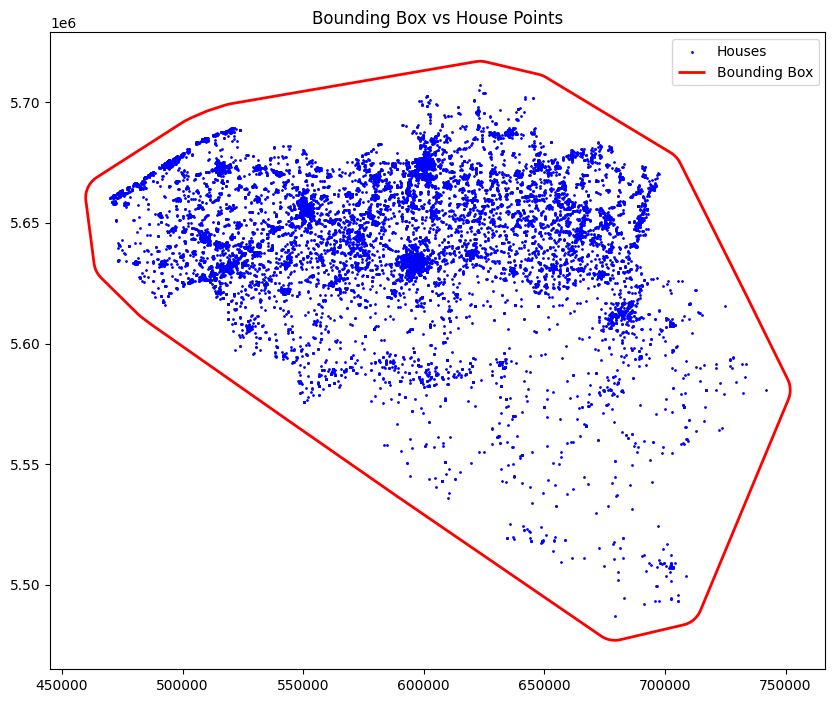

In [12]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, box

# Step 1: Convert to GeoDataFrame
gdf_houses = gpd.GeoDataFrame(
    X_train,
    geometry=[Point(xy) for xy in zip(X_train['lon'], X_train['lat'])],
    crs="EPSG:4326"
)

# Step 2: Project to UTM
utm_crs = gdf_houses.estimate_utm_crs()
gdf_houses = gdf_houses.to_crs(utm_crs)

# Step 3: Define bounding box with buffer
bounds = gdf_houses.total_bounds  # (minx, miny, maxx, maxy)
margin = 10000  # in meters
bbox = (bounds[1] - margin, bounds[0] - margin, bounds[3] + margin, bounds[2] + margin)

# Step 4: Create bounding box polygon
bbox_polygon = box(bbox[1], bbox[0], bbox[3], bbox[2])  # (minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs=gdf_houses.crs)
custom_polygon = gdf_houses.union_all().convex_hull.buffer(10000)
custom_polygon_gdf = gpd.GeoDataFrame(geometry=[custom_polygon], crs=gdf_houses.crs)

# Step 5: Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_houses.plot(ax=ax, color='blue', markersize=1, label='Houses')
custom_polygon_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Bounding Box')
plt.legend()
plt.title("Bounding Box vs House Points")
plt.show()

In [13]:
custom_polygon.area/1e6

43345.69118854298

In [ ]:
43795.60147951723/313.65484905459326*146

20385.96831926096

In [ ]:
custom_polygon = gpd.GeoSeries([custom_polygon], crs=utm_crs).to_crs("EPSG:4326").iloc[0]
tags = {
    "building": True,
    }
gdf_all_features = ox.features.features_from_polygon(custom_polygon, tags=tags)

TypeError: features_from_polygon() got an unexpected keyword argument 'custom_filter'

In [93]:
gdf_all_features.to_file("buildings_314.gpkg", driver="GPKG")

2025-05-01 16:13:17,396 INFO: Created 86,461 records


In [94]:
gdf_all_features

geometry  \
element id                                                              
node    2294616515                            POINT (5.39113 51.0407)   
        2409851026                           POINT (5.34656 50.99107)   
        2720698597                            POINT (5.26393 51.0843)   
        2720698598                            POINT (5.2738 51.06165)   
        2720698600                           POINT (5.28976 51.06174)   
...                                                               ...   
way     1381066319  POLYGON ((5.39247 51.05531, 5.3927 51.05533, 5...   
        1381387728  POLYGON ((5.45426 51.13318, 5.45438 51.13319, ...   
        1381387729  POLYGON ((5.45453 51.13317, 5.4545 51.13317, 5...   
        1381387730  POLYGON ((5.45409 51.133, 5.45417 51.13302, 5....   
        1381387736  POLYGON ((5.44933 51.12895, 5.44933 51.12896, ...   

                      building        leisure          name   sport  \
element id                                                            
node    2294616515      public  sports_centre  Houthalen VV  soccer   
        2409851026      office            NaN     fusemedia     NaN   
        2720698597      chapel            NaN           NaN     NaN   
        2720698598      chapel            NaN           NaN     NaN   
        2720698600      chapel            NaN           NaN     NaN   
...                        ...            ...           ...     ...   
way     1381066319       house            NaN           NaN     NaN   
        1381387728       house            NaN           NaN     NaN   
        1381387729  apartments            NaN           NaN     NaN   
        1381387730  apartments            NaN           NaN     NaN   
        1381387736       house            NaN           NaN     NaN   

                   addr:housename addr:housenumber addr:postcode  \
element id                                                         
node    2294616515            NaN              NaN           NaN   
        2409851026      fusemedia                6          3520   
        2720698597            NaN              NaN           NaN   
        2720698598            NaN              NaN           NaN   
        2720698600            NaN              NaN           NaN   
...                           ...              ...           ...   
way     1381066319            NaN               12           NaN   
        1381387728            NaN                8           NaN   
        1381387729            NaN              NaN           NaN   
        1381387730            NaN                3           NaN   
        1381387736            NaN               27           NaN   

                           addr:street landuse  ... substation museum name:li  \
element id                                      ...                             
node    2294616515                 NaN     NaN  ...        NaN    NaN     NaN   
        2409851026            Halveweg     NaN  ...        NaN    NaN     NaN   
        2720698597                 NaN     NaN  ...        NaN    NaN     NaN   
        2720698598                 NaN     NaN  ...        NaN    NaN     NaN   
        2720698600                 NaN     NaN  ...        NaN    NaN     NaN   
...                                ...     ...  ...        ...    ...     ...   
way     1381066319          Bijendries     NaN  ...        NaN    NaN     NaN   
        1381387728         Nieuwstraat     NaN  ...        NaN    NaN     NaN   
        1381387729                 NaN     NaN  ...        NaN    NaN     NaN   
        1381387730  Blauwe Kielsteegje     NaN  ...        NaN    NaN     NaN   
        1381387736         Vredestraat     NaN  ...        NaN    NaN     NaN   

                   reservation est_height fireplace place_of_worship type  \
element id                                                                  
node    2294616515         NaN        NaN       NaN              NaN  NaN   
        240985102

### New own features

In [9]:
def SpecialTransform(df):
    X = pd.DataFrame()
    X['area_bed'] = df.area/(df.bedrooms+1)
    X['area_foto'] = df.area/df.foto_amount
    X.loc[df['foto_amount'] == 0, 'area_foto'] = 0
    X['ev_area'] = df.energy_value/df.area
    X['miss_tot'] = df.energy_value_miss*1 + df.area_miss*1 + df.advertiser_miss*1 + df.lat_miss*1 + df.subtype_miss*1
    return X

In [10]:
new_cols = SpecialTransform(X_train).columns.to_list()
X_train = X_train.join(SpecialTransform(X_train))
X_val = X_val.join(SpecialTransform(X_val))

In [ ]:
cl_range = list(range(20,101,20)) + list(range(150,301,50))
feateng = feature_engineering(targets=['area', 'bedrooms','energy_value','area_bed','ev_area','area_foto'],
                              transform_type=['median'],
                              comp_type=['diff','frac'],
                              groups=['province','house_type'],
                              features=['lat','lon'],
                              cl_name='clt',
                              clustering=True, 
                              cluster_range=cl_range)

feateng_density = feature_engineering(targets=['area'],
                              transform_type=['count'],
                              comp_type=None,
                              groups=['province','house_type'],
                              features=['lat','lon'],
                              cl_name='clt',
                              clustering=False, 
                              cluster_range=cl_range)

X_train_new = feateng.train(X_train)
X_val_new = feateng.test(X_val)


X_train_new = feateng_density.train(X_train_new)
X_val_new = feateng_density.test(X_val_new)

In [13]:
features_new = features_init + X_train_new.columns.to_list()[25:]
print(len(features_new))

232


### Feature selection on correlation

In [14]:
def getnum(df):
    logic = (df.dtypes=='float64') | (df.dtypes=='float32') | (df.dtypes=='float16')
    num_features = df.dtypes[logic].index.to_list()
    other_features = df.dtypes[~logic].index.to_list()
    return num_features, other_features

In [ ]:
numcols, othcols = getnum(X_train_new)

In [16]:
# plt.figure(figsize=(8, 6))
# sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Spearman Correlation Matrix')
# plt.show()

In [ ]:
numcols, othcols = getnum(X_train_new)
catcols = ['new_building',
 'advertiser',
 'subtype',
 'house_type',
 'area_miss',
 'lat_miss',
 'advertiser_miss',
 'subtype_miss',
 'energy_label_miss',
 'clt20',
 'clt40',
 'clt60',
 'clt80',
 'clt100',
 'clt150',
 'clt200',
 'clt250',
 'clt300']

numcols = numcols + (
['miss_tot',
 'area-clt20-count',
 'area-clt40-count',
 'area-clt60-count',
 'area-clt80-count',
 'area-clt100-count',
 'area-clt150-count',
 'area-clt200-count',
 'area-clt250-count',
 'area-clt300-count',
 'area-province-count',
 'area-house_type-count' ])

In [19]:
only_cor = feature_selection()
selected, _ = only_cor.select(X_train_new[numcols])

In [ ]:
# items_to_remove = {'index', 'id', 'is_appartment', 'added_time', 'postcode', 'energy_label', 'province', 'bedrooms_cat', 'lon_miss' ,'energy_value_miss'}
# othcols = [x for x in othcols if x not in items_to_remove]
features_filt = catcols+selected

### MI scores

In [ ]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# mi_scores = make_mi_scores(X_train_new_new[features_new],y_train.reset_index(drop=True))
# plot_mi_scores(mi_scores)

### Autofeat

In [74]:
X_train_new = X_train_new[catcols + numcols]
X_val_new = X_val_new[catcols + numcols]

In [ ]:
categorical_cols=['house_type', 'lat_miss',  'clt20', 'clt40', 'clt60', 'clt80', 'clt100', 'clt150', 'clt200', 'clt250', 'clt300']
feateng_cols=['area', 'energy_value', 'bedrooms', 'foto_amount']

autofeatures = autofeat.AutoFeatRegressor(feateng_cols=feateng_cols, featsel_runs=2)
X_train_feat = autofeatures.fit_transform(X_train_new[feateng_cols], np.log(y_train.reset_index(drop=True))).drop(columns=feateng_cols)
X_val_feat = autofeatures.transform(X_val_new[feateng_cols]).drop(columns=feateng_cols)

X_train_new = X_train_new.join(X_train_feat)
X_val_new = X_val_new.join(X_val_feat)

## Dimensionality Reduction

### PCA

In [ ]:
# pca_own = PCA_num(n_components=100)
# X_train_red = pca_own.fit_transform(X_train_new_new)

## Model

### KNN

In [100]:
# X_train, y_train = train[['is_appartment','area','lat','lon','foto_amount','energy_value','house_type']].copy(),train['price'].copy()

# X_train_encoded = pd.get_dummies(X_train, columns=['house_type'])

# scaler = StandardScaler()
# X_train_encoded[['area','lat','lon','energy_value','foto_amount']] = scaler.fit_transform(X_train_encoded[['area','lat','lon','energy_value','foto_amount']])

In [101]:
# scores_KNN = []
# for i in range(2,60,2):
#     neigh_model = KNeighborsRegressor(n_neighbors=i, weights='distance')
#     scores_KNN.append(cross_val_score(neigh_model, X_train_encoded, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')*-1)

# scores_KNN = pd.DataFrame(scores_KNN)
# plt.scatter((scores_KNN.index+1)*2, scores_KNN.apply(np.mean, axis=1))

In [102]:
# neigh_model_final = KNeighborsRegressor(n_neighbors=14, weights='distance')
# neigh_model_final.fit(X_train_encoded,y_train)

### XGBoost

In [76]:
#X_train, X_val, y_train, y_val = train_test_split(train[features],train['price'], shuffle=False, test_size=0.2)

dtrain = xgb.DMatrix(X_train_new, label=np.log(y_train.reset_index(drop=True)), enable_categorical=True)
dval = xgb.DMatrix(X_val_new,label=np.log(y_val.reset_index(drop=True)), enable_categorical=True)

evallist = [(dval, 'val')]

param_xgb = {'max_depth': 5, 'eta': 0.1, 'objective': 'reg:squarederror', 'reg_lambda':10, 'reg_alpha':10,}

xgb_regressor = xgb.train(
    params=param_xgb,
    dtrain=dtrain,
    num_boost_round=2000
)
RMSE = np.mean((np.exp(xgb_regressor.predict(dval))-y_val)**2)**(1/2)
print(RMSE)

109499.32399963765


In [69]:
scores = xgb_regressor.get_score(importance_type='gain')
selected_scr, _ = select_features_with_importance(X_train_new[numcols], scores, threshold=0.9)

In [71]:
features_filt_scr = othcols+selected_scr

In [78]:
def featsel(xgb_regressor = xgb_regressor):
    df_scores = pd.DataFrame.from_dict(xgb_regressor.get_score(importance_type='gain'), orient='index', columns=['gain'])
    df_scores = df_scores.join(pd.DataFrame.from_dict(xgb_regressor.get_score(importance_type='cover'), orient='index', columns=['cover']))
    df_scores['gain_rank']=df_scores['gain'].rank(method='min', ascending=False).astype(int)
    df_scores['cover_rank']=df_scores['cover'].rank(method='min', ascending=False).astype(int)
    df_scores['overall_rank'] = df_scores['gain_rank']+df_scores['cover_rank']
    df_scores['overall_rank'] = df_scores['overall_rank'].rank(method='min', ascending=True).astype(int)
    df_scores=df_scores.sort_values(by='overall_rank', ascending=True)
    features = df_scores.index[:-5]
    return features

In [ ]:
features_new_new = features_new
len(features_new)

232

In [78]:
dtrain = xgb.DMatrix(X_train_new[features_new], label=np.log(y_train.reset_index(drop=True)), enable_categorical=True)
dval = xgb.DMatrix(X_val_new[features_new],label=np.log(y_val.reset_index(drop=True)), enable_categorical=True)

evallist = [(dval, 'val')]

param_xgb = {'max_depth': 5, 'eta': 0.1, 'objective': 'reg:squarederror', 'reg_lambda':10, 'reg_alpha':10,}

xgb_regressor = xgb.train(
    params=param_xgb,
    dtrain=dtrain,
    num_boost_round=1000
)
RMSE = np.mean((np.exp(xgb_regressor.predict(dval))-y_val)**2)**(1/2)
print(RMSE)

# features_new_new=featsel(xgb_regressor)
# print(len(features_new_new))

104458.19050112544


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

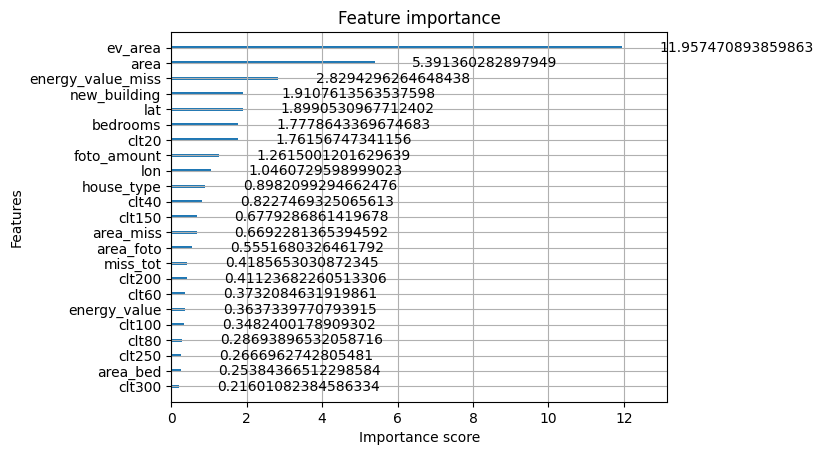

In [27]:
xgb.plot_importance(xgb_regressor, importance_type='gain')

# Test

## Data

In [25]:
# test = pd.read_csv("test.csv", header=0)
test = test.reset_index()
# test = test.drop(columns=['is_promoted','sticker','price_drop_date'])
test['energy_label'] = test['energy_label'].astype('category')
test['new_building'] = test['new_building'].astype('bool')
test['postcode'] = test['postcode'].astype('category')

test['bedrooms_cat'] = pd.cut(test['bedrooms'], bins=[-1,0,1,2,3,4,5,6,float('inf')], labels=['0','1','2','3','4','5','6','7+'])
test['house_type'] = test['subtype'].apply(categorize_house)

## KNN

In [ ]:
# X_test = test[['is_appartment','area','lat','lon','foto_amount','energy_value','house_type']].copy()

# X_test_encoded = pd.get_dummies(X_test, columns=['house_type'])

# scaler = StandardScaler()
# X_test_encoded[['area','lat','lon','energy_value','foto_amount']] = scaler.fit_transform(X_test_encoded[['area','lat','lon','energy_value','foto_amount']])
# X_test_encoded.isna().apply(sum)
# y_test = test['price'].copy()
# y_pred_test = neigh_model_final.predict(X_test_encoded)

## XGBoost

## Error bars

In [615]:
mean_error_1=(y_pred_test/y_test-1).mean()
error_bound_1 = (y_pred_test/y_test-1).std()/len(y_pred_test)**(1/2)*1.96

mean_error_2=abs(y_pred_test/y_test-1).mean()
error_bound_2 = abs(y_pred_test/y_test-1).std()/(len(y_pred_test)**(1/2))*1.96

mean_error_3=((y_pred_test-y_test)**2).mean()**(1/2)
error_bound_3 = abs(y_pred_test-y_test).std()/(len(y_pred_test)**(1/2))*1.96

# Submission metrics

In [510]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=y_pred_test*(1-mean_error_1-error_bound_1)
y_pred_final['upper']=y_pred_test*(1-mean_error_1+error_bound_1)
y_pred_final['pred']=y_pred_test*(1-mean_error_1)

y_pred_final.to_csv(f"xgb_simple_1.csv", index=False)

In [513]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=y_pred_test*(1-mean_error_2-error_bound_2)
y_pred_final['upper']=y_pred_test*(1+mean_error_2+error_bound_2)
y_pred_final['pred']=y_pred_test

y_pred_final.to_csv(f"xgb_simple_2.csv", index=False)

In [512]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=np.maximum(y_pred_test-mean_error_3-error_bound_3,0)
y_pred_final['upper']=y_pred_test+mean_error_3+error_bound_3
y_pred_final['pred']=y_pred_test

y_pred_final.to_csv(f"xgb_simple_3.csv", index=False)